In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
from data_preparation import Preprocessing
from lstm_network import LSTM_RNN_Network
import pickle
import datetime
import time
import matplotlib.pyplot as plt

# -import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import os
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split
from sklearn.metrics.classification import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings

Instructions for updating:
non-resource variables are not supported in the long term


/home/mike/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Set up the GPU to avoid the runtime error: Could not create cuDNN handle...
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
flags = tf.app.flags
FLAGS = flags.FLAGS  


warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ops.reset_default_graph()


# Give the path to the three necessary directory. 
data_dir = '/home/mike/Documents/keras_lstm/LSTM_Sentiment/data/'  
stopwords_file = '/home/mike/Documents/keras_lstm/LSTM_Sentiment/data/stopwords.txt' 
summaries_dir= '/home/mike/Documents/keras_lstm/LSTM_Sentiment/logs/'


n_samples= None # Set n_samples=None to use the whole dataset
batch_size = 100 # Batch size
train_steps = 1000 # Number of training steps
hidden_size= 75 # Hidden size of LSTM layer
embedding_size = 75 # Size of embeddings layer


# random_state = 0 # Random state used for data splitting. Default is 0
learning_rate = 0.01
test_size = 0.2
dropout_keep_prob = 0.5 # 0<dropout_keep_prob<=1. Dropout keep-probability
sequence_len = None # Maximum sequence length
validate_every = 100 # Step frequency in order to evaluate the model using a validation set'

In [5]:
# Prepare the summaries
summaries_dir = '{0}/{1}'.format(summaries_dir, datetime.datetime.now().strftime('%d_%b_%Y-%H_%M_%S'))
train_writer = tf.summary.FileWriter(summaries_dir + '/train')
validation_writer = tf.summary.FileWriter(summaries_dir + '/validation')


# Prepare the model directory
model_name = str(int(time.time()))
model_dir = '{0}/{1}'.format('checkpoints', model_name)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [6]:
# Prepare data and build the TensorFlow graph
data_lstm = Preprocessing(data_dir=data_dir,
                          stopwords_file=stopwords_file,
                          sequence_len=sequence_len,
                          test_size=test_size,
                          val_samples=batch_size,
                          n_samples=n_samples,
                          random_state=100)

lstm_model = LSTM_RNN_Network(hidden_size=[hidden_size],
                              vocab_size=data_lstm.vocab_size,
                              embedding_size=embedding_size,
                              max_length=data_lstm.sequence_len,
                              learning_rate=learning_rate)


# Train the model
sess = tf.Session()
# Initializing the variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

saver = tf.train.Saver()
x_val, y_val, val_seq_len = data_lstm.get_val_data()
train_writer.add_graph(lstm_model.input.graph)


# Lists
train_loss_list = []
val_loss_list = []
step_list = []
sub_step_list = []
step = 0


for i in range(train_steps):
    # Perform the training step
    x_train, y_train, train_seq_len = data_lstm.next_batch(batch_size)
    train_loss, _, summary = sess.run([lstm_model.loss, lstm_model.train_step, lstm_model.merged],
                                      feed_dict={lstm_model.input: x_train,
                                                 lstm_model.target: y_train,
                                                 lstm_model.seq_len: train_seq_len,
                                                 lstm_model.dropout_keep_prob: dropout_keep_prob})
    train_writer.add_summary(summary, i)  # Write train summary for step i (TensorBoard visualization)
    train_loss_list.append(train_loss)
    step_list.append(i)

    print('{0}/{1} train loss: {2:.4f}'.format(i + 1, train_steps, train_loss))

    # Check the validation performance
    if (i + 1) % validate_every == 0:
        val_loss, accuracy, summary = sess.run([lstm_model.loss, lstm_model.accuracy, lstm_model.merged],
                                               feed_dict={lstm_model.input: x_val,
                                                          lstm_model.target: y_val,
                                                          lstm_model.seq_len: val_seq_len,
                                                          lstm_model.dropout_keep_prob: 1})
        validation_writer.add_summary(summary, i)  # Write validation summary for step i (TensorBoard visualization)
        print('   validation loss: {0:.4f} (accuracy {1:.4f})'.format(val_loss, accuracy))
        step = step + 1
        val_loss_list.append(val_loss)
        sub_step_list.append(step)

Loading preprocessed files ...
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
1/1000 train loss: 0.7447
2/1000 train loss: 0.6992
3/1000 train loss: 0.6758
4/1000 train loss: 0.7435
5/1000 train loss: 0.7208
6/1000 train loss: 0.6923
7/1000 train loss: 0.6695
8/1000 train loss: 0.6809
9/1000 train loss: 0.6977
10/1000 train loss: 0.7304
11/1000 train loss: 0.6857
12/1000 train loss: 0.6588
13/1000 train loss: 0.7293
14/1000 train loss: 0.7016
15/1000 train loss: 0.7069
16/1000 train loss: 0.7170
17/1000 trai

242/1000 train loss: 0.0483
243/1000 train loss: 0.0253
244/1000 train loss: 0.0646
245/1000 train loss: 0.0200
246/1000 train loss: 0.0495
247/1000 train loss: 0.0308
248/1000 train loss: 0.0565
249/1000 train loss: 0.0565
250/1000 train loss: 0.0639
251/1000 train loss: 0.0516
252/1000 train loss: 0.0114
253/1000 train loss: 0.0250
254/1000 train loss: 0.0566
255/1000 train loss: 0.0477
256/1000 train loss: 0.0604
257/1000 train loss: 0.1126
258/1000 train loss: 0.0504
259/1000 train loss: 0.0205
260/1000 train loss: 0.0765
261/1000 train loss: 0.0351
262/1000 train loss: 0.0839
263/1000 train loss: 0.0363
264/1000 train loss: 0.0226
265/1000 train loss: 0.0426
266/1000 train loss: 0.0241
267/1000 train loss: 0.0402
268/1000 train loss: 0.0277
269/1000 train loss: 0.0238
270/1000 train loss: 0.0302
271/1000 train loss: 0.0281
272/1000 train loss: 0.0227
273/1000 train loss: 0.0240
274/1000 train loss: 0.0616
275/1000 train loss: 0.0168
276/1000 train loss: 0.0173
277/1000 train loss:

541/1000 train loss: 0.0003
542/1000 train loss: 0.0006
543/1000 train loss: 0.0002
544/1000 train loss: 0.0053
545/1000 train loss: 0.1541
546/1000 train loss: 0.0347
547/1000 train loss: 0.0059
548/1000 train loss: 0.0014
549/1000 train loss: 0.0028
550/1000 train loss: 0.0005
551/1000 train loss: 0.0009
552/1000 train loss: 0.0009
553/1000 train loss: 0.0007
554/1000 train loss: 0.0044
555/1000 train loss: 0.0002
556/1000 train loss: 0.0007
557/1000 train loss: 0.0004
558/1000 train loss: 0.0004
559/1000 train loss: 0.0020
560/1000 train loss: 0.0013
561/1000 train loss: 0.0001
562/1000 train loss: 0.0006
563/1000 train loss: 0.0006
564/1000 train loss: 0.0003
565/1000 train loss: 0.0013
566/1000 train loss: 0.0009
567/1000 train loss: 0.0003
568/1000 train loss: 0.0013
569/1000 train loss: 0.0056
570/1000 train loss: 0.0002
571/1000 train loss: 0.0002
572/1000 train loss: 0.0004
573/1000 train loss: 0.0017
574/1000 train loss: 0.0003
575/1000 train loss: 0.0015
576/1000 train loss:

839/1000 train loss: 0.0007
840/1000 train loss: 0.0007
841/1000 train loss: 0.0000
842/1000 train loss: 0.0001
843/1000 train loss: 0.0000
844/1000 train loss: 0.0000
845/1000 train loss: 0.0003
846/1000 train loss: 0.0007
847/1000 train loss: 0.0002
848/1000 train loss: 0.0000
849/1000 train loss: 0.0000
850/1000 train loss: 0.0001
851/1000 train loss: 0.0000
852/1000 train loss: 0.0000
853/1000 train loss: 0.0001
854/1000 train loss: 0.0000
855/1000 train loss: 0.0000
856/1000 train loss: 0.0001
857/1000 train loss: 0.0000
858/1000 train loss: 0.0000
859/1000 train loss: 0.0004
860/1000 train loss: 0.0008
861/1000 train loss: 0.0001
862/1000 train loss: 0.0000
863/1000 train loss: 0.0000
864/1000 train loss: 0.0002
865/1000 train loss: 0.0001
866/1000 train loss: 0.0000
867/1000 train loss: 0.0001
868/1000 train loss: 0.0000
869/1000 train loss: 0.0000
870/1000 train loss: 0.0001
871/1000 train loss: 0.0002
872/1000 train loss: 0.0000
873/1000 train loss: 0.0001
874/1000 train loss:

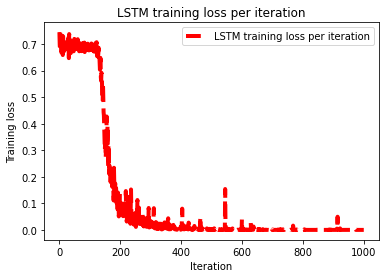

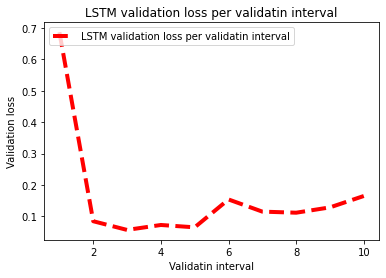

In [7]:
# Plot loss over time
plt.plot(step_list, train_loss_list, 'r--', label='LSTM training loss per iteration', linewidth=4)
plt.title('LSTM training loss per iteration')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.legend(loc='upper right')
plt.show()

# Plot accuracy over time
plt.plot(sub_step_list, val_loss_list, 'r--', label='LSTM validation loss per validatin interval', linewidth=4)
plt.title('LSTM validation loss per validatin interval')
plt.xlabel('Validatin interval')
plt.ylabel('Validation loss')
plt.legend(loc='upper left')
plt.show()

In [8]:
# Save the model such as 'checkpoints/1603001049' in the current directory. 
checkpoint_file = '{}/model.ckpt'.format(model_dir)
save_path = saver.save(sess, checkpoint_file)
print('Model saved in: {0}'.format(model_dir))

Model saved in: checkpoints/1603011876
